# 1D Free energy profiles

Here, we examine the 1D free energy landscape of the toy binding system as a function of distance from the pocket.


In [2]:
import numpy as np

# We're only going to look at a limited set of epsilon values,
#     because for eps < 0.5 kJ/mol binidng/unbinding is too fast
#     and for eps > 3.5 kJ/mol binidng/unbinding is too SLOW!
epsilons = [2.5]
neps = len(epsilons)
ntrials = 20    # there are 20 parallel trajectories
nsnaps = 2000001  # 2 us of simulation with snapshots every 1 ps

# load in all the data
distances = np.zeros( (neps, ntrials, nsnaps) )
maxsnaps = np.zeros( (neps, ntrials) )  # keep track of how many snapshots in each trajectory, for anlaysis
for i in range(neps):
    eps = epsilons[i]
    for j in range(ntrials):
        infile = 'distance_%d.npy'%(j)
        maxsnaps[i,j] = np.load(infile).shape[0]
        if maxsnaps[i,j] < nsnaps:
            print 'WARNING:', infile, 'has only %d < %d snapshots'%(maxsnaps[i,j],nsnaps)
        distances[i,j,0:maxsnaps[i,j]] = np.load(infile)

/Users/yunhuige/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/yunhuige/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


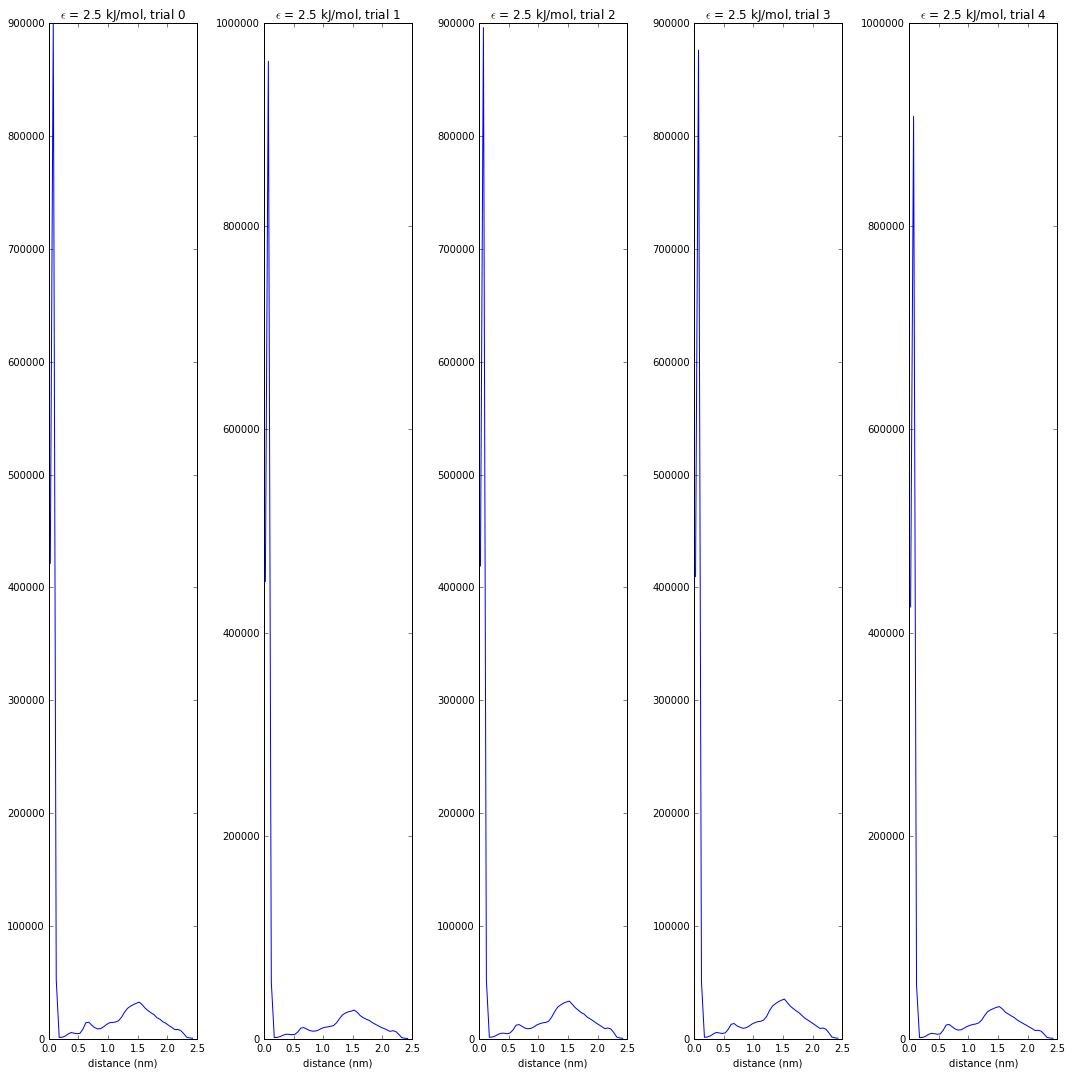

In [3]:
# Let's make histograms of distances
bin_width = 0.05  # nm
max_distance = 2.5 # nm
bin_edges = np.arange(0.0, max_distance, bin_width)  # in nm
bin_centers = (bin_edges[0:-1]+bin_edges[1:])/2.0
nbins = len(bin_centers)
bin_counts = np.zeros( (neps, ntrials, nbins) )
for i in range(neps):
    for j in range(ntrials):
        bin_counts[i,j], edges = np.histogram(distances[i,j,0:maxsnaps[i,j]], bins=bin_edges)

# plot the histograms
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,15))
maxtrials = 5  # don't plot *all* the trials; too busy
panel = 1
for i in range(neps):
    for j in range(maxtrials):
        plt.subplot(neps, maxtrials, panel)
        panel += 1
        plt.plot(bin_centers, bin_counts[i,j])
        plt.title('$\epsilon$ = %1.1f kJ/mol, trial %d'%(epsilons[i],j))
        plt.xlabel('distance (nm)')
plt.tight_layout()
plt.show()

free_energies.shape (1, 20, 49)
free_energies.shape (1, 20, 49)
mean_free_energies.shape (1, 49)
std_free_energies.shape (1, 49)
For $\epsilon$ = 2.5 kJ/mol barrier at 2.425 nm.


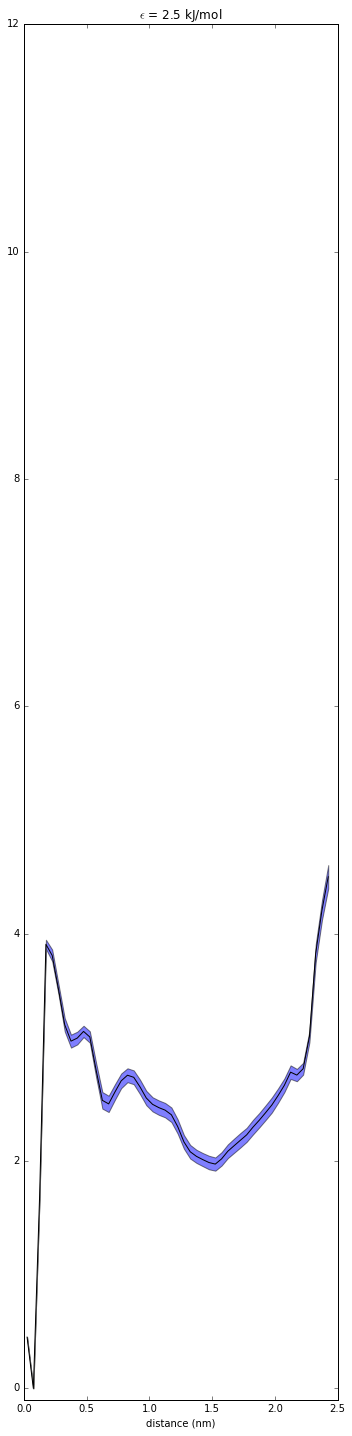

In [4]:
# Next, let's calculate free energy profiles using the variance across trials

RT = 0.5959   # RT in kcal/mol at 300 K
pseudocount = 0.00001
free_energies = -1.0*RT*np.log(bin_counts+pseudocount)
print 'free_energies.shape', free_energies.shape
#print 'free_energies', free_energies

##########
# shift each profile to have the minimum free_energy at zero
min_free_energy = np.min(free_energies, axis=2)
#print 'min_free_energy.shape', min_free_energy.shape
#print 'min_free_energy', min_free_energy
for i in range(neps):
    for j in range(ntrials):
        free_energies[i,j,:] = free_energies[i,j,:] - min_free_energy[i,j]
print 'free_energies.shape', free_energies.shape
#print 'free_energies', free_energies

if (0):     
    mean_free_energies = free_energies.mean(axis=1) # compute the average of a bunch of log-values
else:
    mean_free_energies = -1.0*RT*np.log(bin_counts.sum(axis=1) + pseudocount)  # the log of ALL the counts
    for i in range(neps):
        mean_free_energies[i,:] = mean_free_energies[i,:] - np.min(mean_free_energies[i])
std_free_energies = free_energies.std(axis=1)

print 'mean_free_energies.shape', mean_free_energies.shape
print 'std_free_energies.shape', std_free_energies.shape

plt.figure(figsize=(5,20))
panel = 1
for i in range(neps):
    plt.subplot(neps, 1, panel)
    panel += 1
    plt.fill_between(bin_centers, mean_free_energies[i]-std_free_energies[i], mean_free_energies[i]+std_free_energies[i], alpha=0.5)
    plt.plot(bin_centers, mean_free_energies[i,:], 'k-')
    plt.title('$\epsilon$ = %1.1f kJ/mol'%epsilons[i])
    plt.xlabel('distance (nm)')
    plt.ylim(-0.1, 12)
    
    # report the bin_center the biggest barrier
    barrier_distance = bin_centers[ np.argmax(mean_free_energies[i,:]) ]
    print 'For $\epsilon$ = %1.1f kJ/mol'%epsilons[i], 'barrier at', barrier_distance, 'nm.'
    
plt.tight_layout()
plt.show()